# Experiments

In [232]:
import vectorizers
import kernels
import numpy as np
from sklearn import svm
from sklearn import cross_validation
import pandas as pd

def plot_df(df):
    n_df = df.copy(deep=True)
    for idf in df:
        n_df[idf] =  df[idf].apply(lambda x:float(x.split()[0]))
    n_df.plot(kind='bar')

## loading data

In [101]:
import cPickle as pickle
V_kernels = pickle.load(open('../../data/vect_kernels.pkl','r'))
y = pickle.load(open('../../data/labels.pkl','r'))

In [114]:
V = pickle.load(open('../../data/vects.pkl'))
V.keys()

['bin', 'count', 'tfid', 'norm', 'height']

In [103]:
idx_narr = np.where(y == 0)[0]
idx_other = np.where(y != 0)[0]
idx_narr = np.random.permutation(idx_narr)[:220]
idx = np.concatenate((idx_narr,idx_other))

## loading classifiers

### SVM

,bin,count,height,norm,tfid
rbf,0.70 (+/- 0.03),0.71 (+/- 0.02),0.71 (+/- 0.02),0.35 (+/- 0.00),0.36 (+/- 0.01)
lin,0.71 (+/- 0.03),0.80 (+/- 0.03),0.80 (+/- 0.03),0.58 (+/- 0.01),0.65 (+/- 0.03)
cos_sim,0.70 (+/- 0.05),0.62 (+/- 0.05),0.62 (+/- 0.05),0.62 (+/- 0.05),0.69 (+/- 0.05)


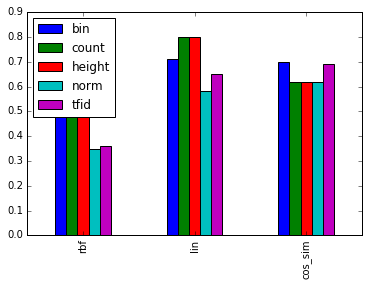

In [234]:
Kernels = ['rbf', 'lin', 'cos_sim']
representations = ['bin', 'count', 'tfid', 'norm', 'height']

results = []
for k in Kernels:
    d = {}
    for rep in representations:
        K = V_kernels[k][rep]
        K = K[idx][:,idx]
        svm_clf = svm.SVC(kernel="precomputed")
        scores = cross_validation.cross_val_score(svm_clf,K,y[idx],cv=5)        
        d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
        
    results.append(d)
svm_res = pd.DataFrame(results,index=Kernels)
plot_df(svm_res)
svm_res

### Random Forest

,bin,count,height,norm,tfid
0,0.67 (+/- 0.06),0.75 (+/- 0.03),0.79 (+/- 0.09),0.73 (+/- 0.09),0.75 (+/- 0.04)


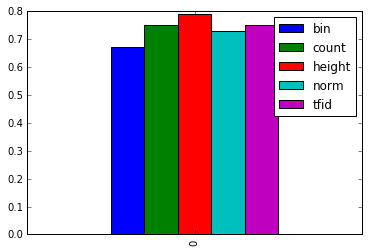

In [235]:
from sklearn import ensemble
results = []
d = {}
for rep in representations:
    rand_forest = ensemble.RandomForestClassifier()
    scores = cross_validation.cross_val_score(rand_forest,V[rep][idx],y[idx],cv=5)        
    d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
results.append(d)
rand_forest_res = pd.DataFrame(results,index=None)
plot_df(rand_forest_res)
rand_forest_res

### KNN

,bin,count,height,norm,tfid
eucl_dist,0.63 (+/- 0.05),0.71 (+/- 0.04),0.71 (+/- 0.04),0.59 (+/- 0.09),0.65 (+/- 0.06)
mink_dist,0.63 (+/- 0.05),0.71 (+/- 0.04),0.71 (+/- 0.04),0.59 (+/- 0.09),0.65 (+/- 0.06)


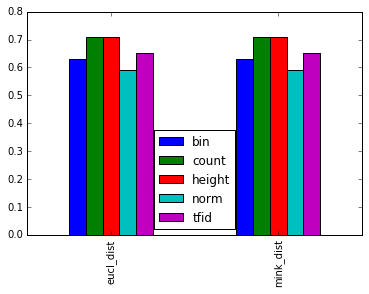

In [236]:
metrics = ['eucl_dist','mink_dist']
representations = ['bin', 'count', 'tfid', 'norm', 'height']

results = []
for k in metrics:
    d = {}
    for rep in representations:
        K = V_kernels[k][rep]
        K = K[idx][:,idx]
        knn_clf = neighbors.KNeighborsClassifier(metric="precomputed")
        scores = cross_validation.cross_val_score(knn_clf,K,y[idx],cv=5)        
        d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
    results.append(d)
    
knn_res = pd.DataFrame(results,index=metrics)
plot_df(knn_res)
knn_res

### MaxEnt

,bin,count,height,norm,tfid
0,0.73 (+/- 0.06),0.79 (+/- 0.02),0.79 (+/- 0.02),0.58 (+/- 0.05),0.65 (+/- 0.05)


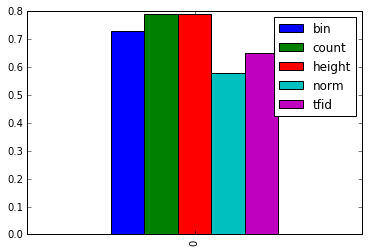

In [238]:
from sklearn import linear_model

results = []
d = {}
for rep in representations:
    maxent = linear_model.LogisticRegression()
    scores = cross_validation.cross_val_score(maxent,V[rep][idx],y[idx],cv=5)        
    d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
results.append(d)
maxent_res = pd.DataFrame(results,index=None)
plot_df(maxent_res)
maxent_res

### Treekernel

In [ ]:
print(K2)
clf4  = svm.SVC(kernel='precomputed')
clf4.fit(K2,y)

## Ajout de features

In [ ]:
V_pos_norm = pickle.load(open('../data/pos_tags/pos_norm_vects.pkl',"r"))

,bin,count,height,norm,tfid
0,0.77 (+/- 0.07),0.83 (+/- 0.03),0.83 (+/- 0.03),0.86 (+/- 0.05),0.88 (+/- 0.06)


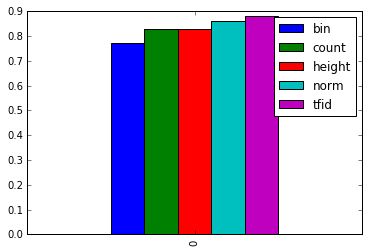

In [240]:
from sklearn import linear_model

V_plus = {}
for key in V.keys():
    V_plus[key] = np.hstack((V[key],V_pos_norm))

results = []
d = {}
for rep in representations:
    maxent = linear_model.LogisticRegression()
    scores = cross_validation.cross_val_score(maxent,V_plus[rep][idx],y[idx],cv=5)        
    d[rep] = "   %0.2f   (+/- %0.2f) " % (scores.mean(), scores.std() * 2)
results.append(d)
maxent_res = pd.DataFrame(results,index=None)
plot_df(maxent_res)
maxent_res

## matrices de confusion

['rbf', 'lin', 'eucl_dist', 'cos_sim', 'mink_dist']
['bin', 'count', 'tfid', 'norm', 'height']


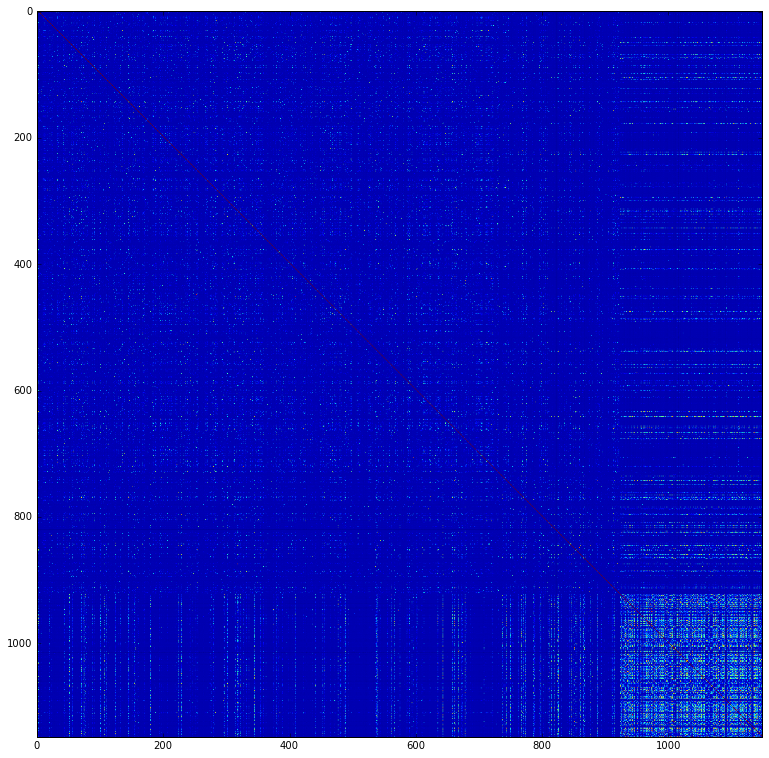

In [53]:
print vect_kernels.keys()
print vect_kernels['rbf'].keys()
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(13,13))
plt.imshow(vect_kernels['rbf']['norm']+vect_kernels['rbf']['height'])
plt.show()